In [1]:
DATA_DIR = 'F:\\technopolis\\data\\'
GRAPH_PATH = 'F:\\technopolis\\graphs\\'

SAMPLE_FRAC = 1


FEATURES = [
    'DeviceClass',
    'DeviceName',
    'DeviceBrand',
    'DeviceCpu',
    'DeviceCpuBits',
    'OperatingSystemClass',
    'OperatingSystemName',
    'OperatingSystemVersion',
    'OperatingSystemNameVersion',
    'OperatingSystemVersionBuild',
    'LayoutEngineClass',
    'LayoutEngineName',
    'LayoutEngineVersion',
    'LayoutEngineVersionMajor',
    'LayoutEngineNameVersion',
    'LayoutEngineNameVersionMajor',
    'AgentClass',
    'AgentName',
    'AgentVersion',
    'AgentVersionMajor',
    'AgentNameVersion',
    'AgentNameVersionMajor',
    'from',
    'to',
    'url',
    'requestType',
    'operation'
]

In [2]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa

from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin
from sklearn import decomposition

# %matplotlib inline
from matplotlib import pyplot as plt

pd.set_option("display.precision", 2)

### Модели преобразования данных

In [3]:
class HashingTrick(TransformerMixin):
    
    _default_hashing_trick_modulars = {
        'DeviceClass': 100,
        'DeviceName': 100,
        'DeviceBrand': 100,
        'DeviceCpu': 100,
        'DeviceCpuBits': 100,
        'OperatingSystemClass': 100,
        'OperatingSystemName': 100,
        'OperatingSystemVersion': 100,
        'OperatingSystemNameVersion': 100,
        'OperatingSystemVersionBuild': 100,
        'LayoutEngineClass': 100,
        'LayoutEngineName': 100,
        'LayoutEngineVersion': 100,
        'LayoutEngineVersionMajor': 100,
        'LayoutEngineNameVersion': 100,
        'LayoutEngineNameVersionMajor': 100,
        'AgentClass': 100,
        'AgentName': 100,
        'AgentVersion': 100,
        'AgentVersionMajor': 100,
        'AgentNameVersion': 100,
        'AgentNameVersionMajor': 100,
        'from': 100,
        'to': 100,
#         'url': 10000000,
        'requestType': 100,
        'operation': 100
    }
    
    def __init__(self, FEATURES=FEATURES, hashing_trick_modulars = _default_hashing_trick_modulars):
        self.hashing_trick_modulars = hashing_trick_modulars
        self.FEATURES = FEATURES
    
    def set_params(self, **kwargs):
        """Set the parameters of this estimator."""
    
    def get_params(self, **kwargs):
        return {"hashing_trick_modulars": self.hashing_trick_modulars}
        
    def _hashing_trick(self, x, n):
        return hash(x) % n

    def _column_hashing_trick(self, col_name):
        self.http[col_name] = self.http[col_name].apply(self._hashing_trick, args=(self.hashing_trick_modulars[col_name],))
  
    def fit_transform(self, X, *_):
        return self.transform(X)
        
    def transform(self, X, *_):
        self.http = X
        for feature in self.FEATURES:
            self._column_hashing_trick(feature)

        return self.http
    
    def fit(self, *_):
        return self

In [4]:
ht = HashingTrick()
ohe = OneHotEncoder(handle_unknown='ignore')

### Загрузка данных из паркета

In [5]:
X = pq.read_table(DATA_DIR + 'HTTPRequests-20180217_1718_parsedUAA_parquet.parquet', columns=FEATURES ).to_pandas().sample(frac=SAMPLE_FRAC)
y = pq.read_table(DATA_DIR + 'HTTPRequests-20180217_1718_parsedUAA_parquet.parquet', columns=['isBot'] ).to_pandas().sample(frac=SAMPLE_FRAC)

### Преобразование данных

In [6]:
# X_ht = ht.transform(X)
# X_ohe = ohe.fit_transform(X_ht)
# y = y.values.ravel()


### Преобразует номер фичи в её имя

In [7]:
# def feature_name(i):
#     a_from = ohe.feature_indices_[:ohe.feature_indices_.shape[0] - 1]
#     a_to = ohe.feature_indices_[1:]
#     for i_from, i_to,k in zip(a_from, a_to, range(0, a_from.shape[0])):
#         if (i in range(i_from, i_to)):
#             return FEATURES[k]
#     return 'unknown'

In [8]:
# feature_name(7), feature_name(43242), feature_name(543254325432543254325), feature_name(-1)

In [9]:


# # Прогоним встроенный в sklearn PCA
# pca = decomposition.PCA(n_components=5)
# # X_centered = X - X.mean(axis=0)
# X_pca = pca.fit_transform(X_ohe.toarray())

# # И нарисуем получившиеся точки в нашем новом пространстве

# # plt.plot(X_pca[y==0,0], X_pca[y==0,1],  'go', label='users')
# # plt.legend(loc=0);
# # plt.figure()
# # plt.plot(X_pca[y==1,0], X_pca[y==1,1], 'ro', label='bots')
# # plt.legend(loc=0);

# print(pca.components_)
# pca.explained_variance_

In [10]:
# components_ = pd.DataFrame(pca.components_.T)

In [11]:
# components_['id'] = ohe.active_features_

In [12]:
# components_['feature'] = components_['id'].apply(feature_name)

In [13]:
# components_['feature'].value_counts()

In [14]:
# components_[['0_sqr', '1_sqr', '2_sqr', '3_sqr', '4_sqr']] = components_[[0, 1, 2, 3, 4]].apply(lambda x: x*x)

In [15]:
# grouped = components_.groupby('feature').sum().sort_values('0_sqr')
# grouped

In [16]:
# grouped['0_sqr'].values.sum()

In [17]:
# pca.explained_variance_ 

In [18]:
y = y.values.ravel()

DeviceClass


F:\conda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


DeviceName
DeviceBrand
DeviceCpu
DeviceCpuBits


KeyboardInterrupt: 

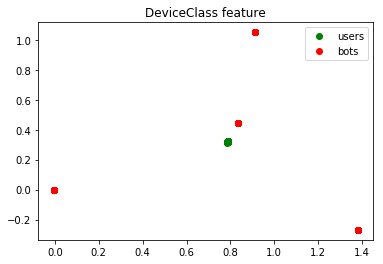

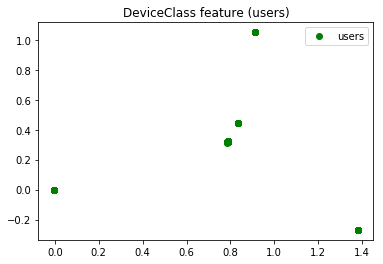

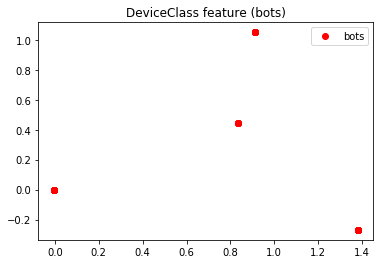

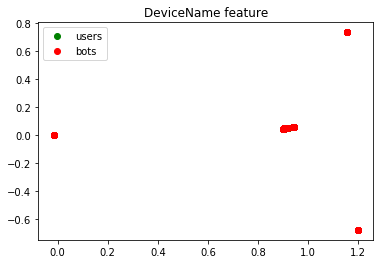

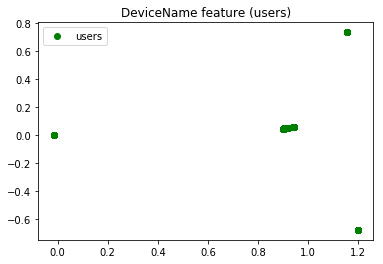

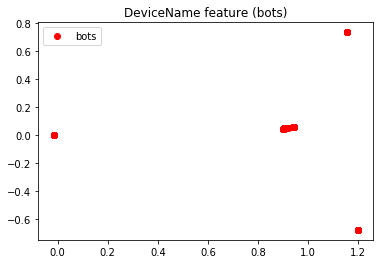

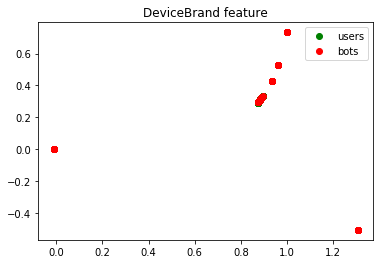

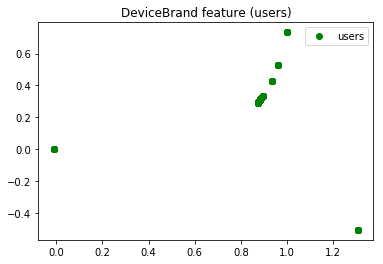

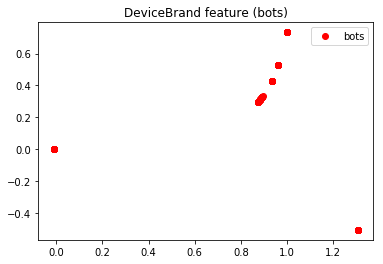

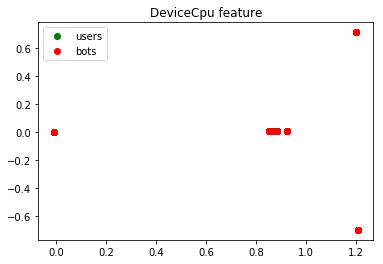

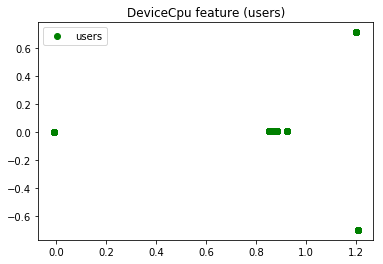

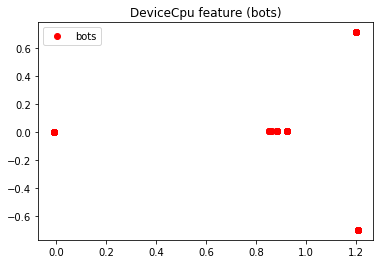

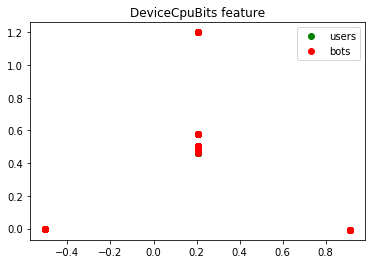

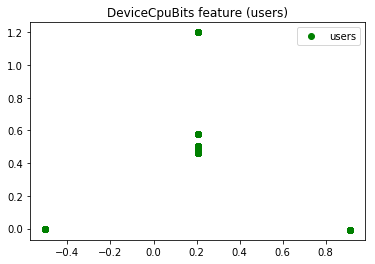

In [19]:

import os

for feature in FEATURES:
    if not os.path.isdir(os.path.join(GRAPH_PATH, 'feature_clusters', feature)):
        os.mkdir(os.path.join(GRAPH_PATH, 'feature_clusters', feature))
    print(feature)
    pca = decomposition.PCA(n_components=2)
    
    ht = HashingTrick([feature])
    X_f = ht.transform(X[[feature]])
    X_f = ohe.fit_transform(X_f)
    X_pca = pca.fit_transform(X_f.toarray())
    plt.figure()
    plt.plot(X_pca[y==0,0], X_pca[y==0,1],  'go', label='users')
    plt.legend(loc=0);
    plt.plot(X_pca[y==1,0], X_pca[y==1,1], 'ro', label='bots')
    plt.title('{} feature'.format(feature))
    plt.savefig(os.path.join(GRAPH_PATH, 'feature_clusters', feature, feature + '.png'), dpi=900)
    plt.legend(loc=0);
    
    plt.figure()
    plt.plot(X_pca[y==0,0], X_pca[y==0,1],  'go', label='users')
    plt.title('{} feature (users)'.format(feature))
    plt.legend(loc=0);
    plt.savefig(os.path.join(GRAPH_PATH, 'feature_clusters', feature, feature + '_users' + '.png'), dpi=900)
    
    plt.figure()
    plt.plot(X_pca[y==1,0], X_pca[y==1,1],  'ro', label='bots')
    plt.title('{} feature (bots)'.format(feature))
    plt.legend(loc=0);
    plt.savefig(os.path.join(GRAPH_PATH, 'feature_clusters', feature, feature + '_bots' + '.png'), dpi=900)
    
    